In [4]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [5]:
# load data

crimes_df = pd.read_csv('Crimes_Dataset.csv')
suspects_df = pd.read_csv('Suspects_Dataset.csv')

print(crimes_df.info())
print(suspects_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Index_Crimes           10000 non-null  int64  
 1   Date                   10000 non-null  object 
 2   Monster involved       10000 non-null  object 
 3   Days of Investigation  10000 non-null  float64
 4   Region                 9998 non-null   object 
 5   Crime Type             10000 non-null  object 
 6   Crime Weapon           7403 non-null   object 
 7   Time of Day            10000 non-null  object 
 8   Evidence Found         9995 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 703.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   importtIndex_Monster  10000 non-null 

In [6]:
# convert everything to lowercase

def lower(df):
    df.columns = df.columns.str.lower()
    df = df.apply(lambda col:col.str.lower() if col.dtype == 'object' else col)
    return df

crimes_df = lower(crimes_df)
suspects_df = lower(suspects_df)

print(crimes_df.head(5))
print()
print(suspects_df.head(5))

   index_crimes        date monster involved  days of investigation    region  \
0          6316  2020-02-18         skeleton                   77.0  mountain   
1          4731  2022-09-01         werewolf                   48.0    forest   
2          1750  2022-08-03            ghost                   31.0    castle   
3          4789  2023-10-18            witch                   29.0     swamp   
4          4567  2021-03-25            ghost                   59.0   village   

            crime type crime weapon time of day evidence found  
0  nightly disturbance          NaN       night          bones  
1              assault       pistol       night          teeth  
2  nightly disturbance          NaN       night        potions  
3                arson       pistol        dawn        potions  
4  nightly disturbance       pistol       night        potions  

   importtindex_monster  monster criminal record    age gender  height in cm  \
0                  2101    witch          

In [7]:
# merge Crime_Dataset.csv and Suspects_Dataset.csv with index

df = pd.merge(crimes_df, suspects_df, left_on = 'index_crimes', right_on = 'importtindex_monster')
df = df.drop(columns = ['monster', 'importtindex_monster'], axis = 1)
df.head(5)

,index_crimes,date,monster involved,days of investigation,region,crime type,crime weapon,time of day,evidence found,criminal record,age,gender,height in cm,speed level,strength level,allergy,favorite food
0,6316,2020-02-18,skeleton,77.0,mountain,nightly disturbance,NaN,night,bones,yes,1.0,f,152.0,26.0,8.0,silver,lasagna
1,4731,2022-09-01,werewolf,48.0,forest,assault,pistol,night,teeth,no,53.0,m,171.0,87.0,7.0,silver,pesto pasta
2,1750,2022-08-03,ghost,31.0,castle,nightly disturbance,NaN,night,potions,no,1634.0,m,185.0,59.0,2.0,sunlight,humans
3,4789,2023-10-18,witch,29.0,swamp,arson,pistol,dawn,potions,no,322.0,m,169.0,23.0,3.0,pumpkin,lasagna
4,4567,2021-03-25,ghost,59.0,village,nightly disturbance,pistol,night,potions,no,757.0,f,170.0,36.0,10.0,garlic,rats


In [8]:
# identify input features

X = df.drop(columns = ['monster involved', 'index_crimes'])

categorical_features = X.select_dtypes(include = ['object']).columns
numerical_features = X.select_dtypes(include = ['number']).columns

print(categorical_features)
print()
print(numerical_features)
print()
print(X.head(5))

Index(['date', 'region', 'crime type', 'crime weapon', 'time of day',
       'evidence found', 'criminal record', 'gender', 'allergy',
       'favorite food'],
      dtype='object')

Index(['days of investigation', 'age', 'height in cm', 'speed level',
       'strength level'],
      dtype='object')

         date  days of investigation    region           crime type  \
0  2020-02-18                   77.0  mountain  nightly disturbance   
1  2022-09-01                   48.0    forest              assault   
2  2022-08-03                   31.0    castle  nightly disturbance   
3  2023-10-18                   29.0     swamp                arson   
4  2021-03-25                   59.0   village  nightly disturbance   

  crime weapon time of day evidence found criminal record     age gender  \
0          NaN       night          bones             yes     1.0      f   
1       pistol       night          teeth              no    53.0      m   
2          NaN       night        potions  

In [9]:
# identify target

Y = df['monster involved']

In [10]:
# handle missing values

# fill in missing 'crime weapon' with 'unknown'
X['crime weapon'] = X['crime weapon'].fillna('unknown')

# impute in missing numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# impute in missing categorical data & one-hot encode
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
])

In [11]:
# combine numerical & categorical data
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

# apply transformed data to Random Forest Model

model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 100, random_state = 42))
])

In [12]:
# split data to 80% train and 20% test data sets

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [13]:
# train

model_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# test

Y_predict = model_pipeline.predict(X_test)

In [ ]:
# important measurements

# how many % of overall predictions were correct:
accuracy = accuracy_score(Y_test, Y_predict)

# (reliability of a guess) - if one type is predicted - how likely is it to be the correct prediction:
precision = precision_score(Y_test, Y_predict, average='weighted')

# (completeness of a class) 1 - how many Monsters does it miss per type:
recall = recall_score(Y_test, Y_predict, average='weighted')

# balancing between precision and recall
f1 = f1_score(Y_test, Y_predict, average='weighted')

# report by Type
report = classification_report(Y_test, Y_predict)

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1 score:", f1)
print("\n")
print("classification report:\n\n", report)



accuracy: 0.9755
precision: 0.975602922030106
recall: 0.9755
f1 score: 0.9754995620156203


classification report:

               precision    recall  f1-score   support

       ghost       0.96      0.99      0.97       338
    skeleton       0.96      0.95      0.96       317
     vampire       0.97      0.97      0.97       328
    werewolf       0.99      0.98      0.98       364
       witch       0.99      0.97      0.98       320
      zombie       0.99      0.98      0.99       333

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



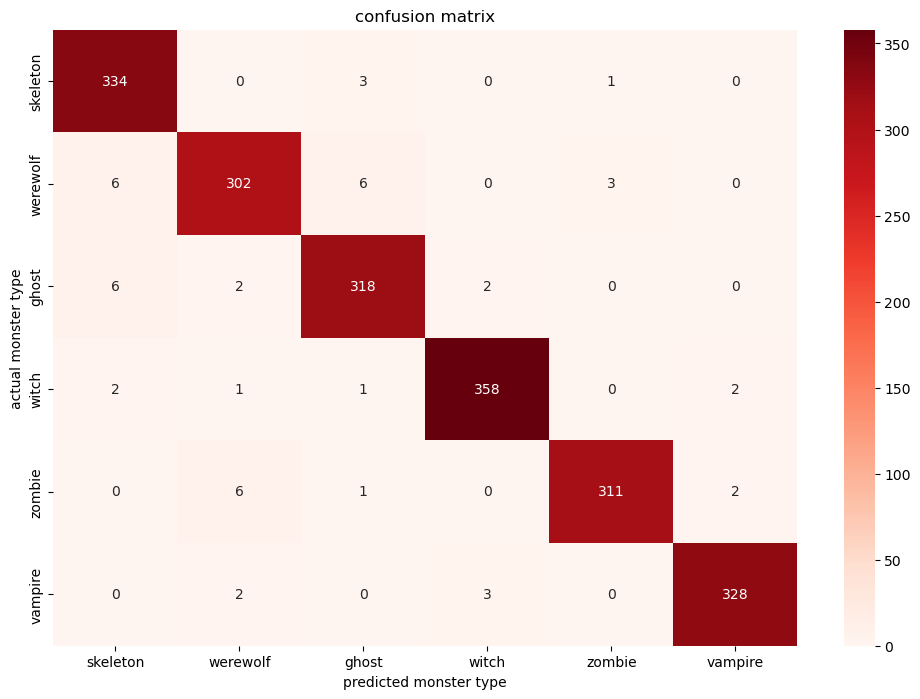

In [42]:
conf_matrix = confusion_matrix(Y_test, Y_predict)
plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=Y.unique(), yticklabels=Y.unique())
plt.title('confusion matrix')
plt.xlabel('predicted monster type')
plt.ylabel('actual monster type')
plt.show()


In [ ]:
# get feature names from all numerical features
numerical_features = X_test.select_dtypes(include=['number']).columns

# get feature names from all not numerical features
categorical_features_names = model_pipeline.named_steps['preprocessor'] \
    .named_transformers_['categorical']['encoder'] \
    .get_feature_names_out(model_pipeline.named_steps['preprocessor'] \
    .transformers_[1][2])

# combine feature names
all_features = list(numerical_features) + list(categorical_features_names)

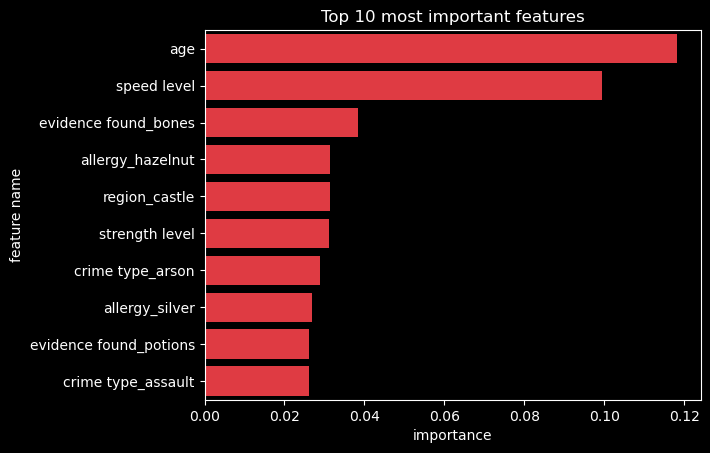

In [ ]:
# plot
importances = model_pipeline.named_steps['classifier'].feature_importances_
df_importances = pd.DataFrame(importances)
df_importances['features'] = all_features
df_importances.rename(columns={0 : 'importance'}, inplace=True)
df_importances.sort_values(by='importance', inplace=True, ascending=False)
df_importances.head(10).plot(x= 'features', kind='barh').invert_yaxis()

# formatting
plt.gca().set_facecolor("#000000") 
plt.gcf().set_facecolor('#000000') 

bars = plt.barh(y= df_importances['features'], width= df_importances['importance'], color="#df3b43")
plt.xlabel("importance", color="white")
plt.ylabel("feature name", color="white")
plt.xticks(rotation=0, color="white")
plt.title("Top 10 most important features", color="white")
plt.legend().set_visible(False)
plt.show()

In [97]:
# saving the model
joblib.dump(model_pipeline, 'trained_model_pipeline.pkl')


['trained_model_pipeline.pkl']